Use LSA to identify related questions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from itertools import chain
from collections import Counter
import pickle
import scipy.io as scio
from sklearn.decomposition import TruncatedSVD
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
from scipy.stats import pearsonr

In [2]:
dat = pd.read_csv("../raw_data/local-dev/Questions.csv", encoding='latin1')
dat['Title'].fillna("None", inplace=True)
dat['Score'].fillna(0, inplace=True)

In [3]:
dat.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,17532666,2556416.0,2013-07-08T17:33:15Z,0,Migrating to Twitter API version 1.1 (?) [dupl...,<p>I am quite new to Twitter API. I have updat...
1,10540999,161085.0,2012-05-10T19:37:09Z,4,How to configure a Clojure library at runtime?,"<p>As a Clojure learning exercise, I am portin..."
2,34126234,3769629.0,2015-12-07T04:02:48Z,0,Handling JSON file with python,<p>I'm developing a plugin for sublime text an...
3,23721800,2474015.0,2014-05-18T12:19:40Z,0,Getting a MemoryError because list/array is to...,<h2>Problem</h2>\n\n<p>I have to download <cod...
4,10126239,891306.0,2012-04-12T14:59:27Z,3,Reading output with telnetlib in realtime,<p>I'm using Python's telnetlib to telnet to s...


In [4]:
# select a sample - results will improve without sampling in tf-idf caluculations, but due to
# Kaggle kernel memory limit we have to make a compromise here.
selected_ids = np.random.choice(range(dat.shape[0]), 10000, replace=False)
sample = dat.loc[selected_ids, :]
sample.shape

(10000, 6)

In [5]:
def purify_string(html):
    return re.sub('(\r\n)+|\r+|\n+', " ", re.sub('<[^<]+?>', '', html))

In [6]:
corpus = sample.ix[:, 'Body'].apply(purify_string)

/Users/adantonison/.virtualenvs/cca-project/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [7]:
def combine_title_body(tnb):
    return tnb[0] + " " + tnb[1]

In [8]:
p = Pool(8)
combined_corpus = p.map(combine_title_body, zip(dat['Title'], corpus))
p.close()

In [9]:
combined_corpus[:2]

['Migrating to Twitter API version 1.1 (?) [duplicated] I\'m trying to setup my django administration page with HighCharts so I can allow admins to visualize some of the data easily.  I can currently get the total number of riders for all objects within the PeopleCount model (totalPeople), but when I try filtering by a StopID (totalPeopleByStop), it breaks.  Here is my models.py, along with the aforementioned methods in the PeopleCount class: from django.db import models from django.template.loader import render_to_string class Vehicle(models.Model):     VehID = models.AutoField(primary_key=True)     Title = models.CharField(max_length=40)     Driver = models.CharField(max_length=25) def __unicode__(self):     return self.Title class Location(models.Model):     LocID = models.AutoField(primary_key=True)     VehID = models.ForeignKey(\'Vehicle\')     Latitude = models.DecimalField(max_digits=10, decimal_places=6)     Longitude = models.DecimalField(max_digits=10, decimal_places=6)     S

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adantonison/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adantonison/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lem = WordNetLemmatizer()
def cond_tokenize(t):
    if t is None:
        return []
    else:
        return [lem.lemmatize(w.lower()) for w in word_tokenize(t)]

p = Pool(8)
tokens = list(p.imap(cond_tokenize, combined_corpus))
p.close()

In [13]:
# stops = stopwords.words('english')
pure_tokens = [" ".join(sent) for sent in tokens]

In [14]:
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english', ngram_range=[1, 1], sublinear_tf=True)
tfidf = vectorizer.fit_transform(pure_tokens)

In [15]:
idfs = pd.DataFrame([[v, k] for k, v in vectorizer.vocabulary_.items()], columns=['id', 'word']).sort_values('id')
idfs['idf'] = vectorizer.idf_
idfs.sort_values('idf').head(10)

,id,word,idf
72,1407,python,1.388561
104,1874,using,1.938636
146,406,code,1.942478
76,738,file,2.042805
118,1032,like,2.055365
22,910,import,2.143919
33,540,def,2.240391
114,1918,want,2.246980
338,1355,print,2.253263
54,675,error,2.264885


### Compress using SVD

In [16]:
tsvd = TruncatedSVD(n_components=500)
transformed = tsvd.fit_transform(tfidf)

In [17]:
np.sum(tsvd.explained_variance_ratio_)

0.6080938894680588

In [18]:
transformed.shape

(10000, 500)

In [19]:
# calculate pairwise cosine distance
D = distance.pdist(transformed, 'cosine')

In [20]:
# hierarchical clustering - tree calculation
L = hierarchy.linkage(D)

In [21]:
# mean distance between clusters
np.mean(D)

0.9309584208549853

In [22]:
# split clusters by criterion. Here 0.71 is used as the inconsistency criterion. Adjust the
# number to change cluster sizes
cls = hierarchy.fcluster(L, 0.71, criterion='inconsistent')

In [23]:
df_cls = pd.DataFrame({'Pos': selected_ids, 'Cluster': cls})
cnts = df_cls.groupby('Cluster').size().sort_values(ascending=False)
cnts.sort_values(ascending=False).head()

Cluster
1087    30
1541    27
1093    22
1091    20
1416    18
dtype: int64

In [24]:
# add clusters to question data
bc = pd.concat([sample, df_cls.set_index('Pos')], axis=1)
bc.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,Cluster
Pos,,,,,,,
6016,22374013,1028796.0,2014-03-13T09:20:28Z,0,Django filter from within models,<p>I'm trying to setup my django administratio...,1832
830,34662353,5719358.0,2016-01-07T18:19:46Z,0,"""Cannot update File menu Recent Files list [Er...",<p>I have no idea why this happens and then it...,6428
4194,32382791,5197617.0,2015-09-03T18:17:29Z,1,How to get list of class instances from file u...,<p>I have 2 classes: Group and student. I crea...,758
7952,34951089,4759209.0,2016-01-22T16:11:56Z,1,Send a list to django within an ajax GET request,<p>I found a lot of posts here and outside tal...,3184
202,25957249,916780.0,2014-09-21T08:18:05Z,1,Python: Implementing concurrent DNS requests (...,<p>I'm trying to write a python script that se...,4930


In [25]:
# calculate cluster stats
stats = bc.groupby('Cluster')['Score'].describe().unstack()

In [34]:
stats['count'].sort_values(ascending=False).head()

Cluster
1087    30.0
1541    27.0
1093    22.0
1091    20.0
1416    18.0
dtype: float64

/Users/adantonison/.virtualenvs/cca-project/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


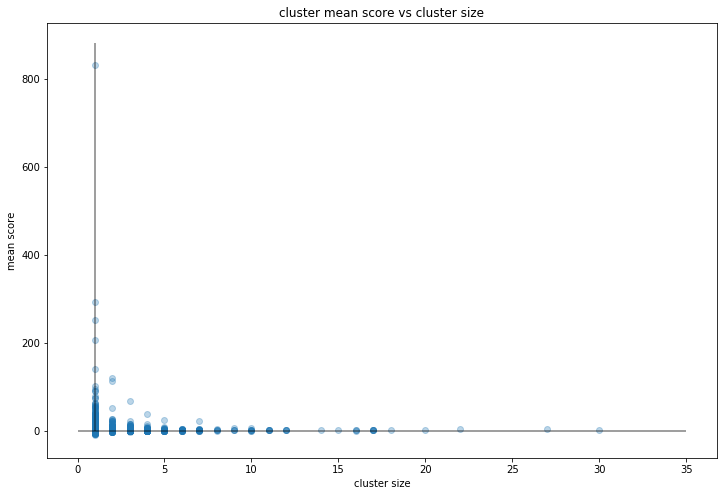

In [35]:
plt.figure(figsize=(12, 8))
plt.hlines([0], xmin=0, xmax=np.max(stats['count']) + 5, alpha=0.5)
plt.vlines([1], ymin=0, ymax=np.max(stats['mean']) + 50, alpha=0.5)
plt.scatter(stats['count'], stats['mean'], alpha=0.3)
plt.title("cluster mean score vs cluster size")
plt.xlabel("cluster size")
plt.ylabel("mean score")
plt.show()

### Check if clusters make sense

In [36]:
bc.loc[bc['Cluster'] == cnts.index[0]][['Score', 'Title', 'Body']]

,Score,Title,Body
Pos,,,
9600,3,Appending to a Python list without making list...,<p>I start out with an empty list and prompt t...
1202,0,Iterable error in word count Python 3.3 program,<p>I'm trying to complete a simple word-count ...
1350,-1,How to use for loop in the write method?,<p>The program is supposed to read a given fil...
8115,-1,Converting a Text File to a String in Python,<p>I am new to python and am trying to find th...
5482,6,checking if a string is in alphabetical order ...,<p>I've put together the following code to che...
3368,2,Print horizontal with for in Python 2.7,<p>I have issues with python that i cant figur...
1897,0,"I'm creating a function to search for "" unique...",<p>I'm creating a function to search for <stro...
9175,3,"What part of speech does ""s"" stand for in NLTK...",<p>I have a list of GRE words which I am getti...
6336,1,how to count the total number of items for the...,<p>I want to get count the total items for the...


In [37]:
bc.loc[bc['Cluster'] == cnts.index[1]][['Score', 'Title', 'Body']]

,Score,Title,Body
Pos,,,
7661,3,retrieve series of slices of column headers ba...,<p>consider the dataframe <code>df</code></p>\...
5779,34,"Strings in a DataFrame, but dtype is object",<p>Why does Pandas tell me that I have objects...
8036,2,Dropping multilevel columns from lists of dict...,"<p>I have a dataframe with multilevel columns,..."
573,1,pandas Dataframe set value fails,<p>I been following the documentation but it k...
7257,1,Grouping entries in pandas dataframe,<p>Hello I have a dataframe like this</p>\n\n<...
6626,1,Using 'or' in a Dataframe,<p>I can find where my DataFrame has <code>ALE...
6440,1,Filling in missing data in pandas dataframe,<p>I have a Pandas dataframe with two indexes<...
753,42,how do I insert a column at a specific column ...,<p>Can I insert a column at a specific column ...
1252,0,pandas data frame transform INT64 columns to b...,"<p>Some column in dataframe df, df.column, is ..."


In [38]:
bc.loc[bc['Cluster'] == cnts.index[2]][['Score', 'Title', 'Body']]

,Score,Title,Body
Pos,,,
5350,0,argparse : ValueError whe using --help or -h o...,<p>Whe using argparse I get this weird ValueEr...
8668,0,Python argcomplete: can't see second level sub...,"<p>I use <a href=""https://pypi.python.org/pypi..."
5042,1,Python Specify date format with optparse,<p>I'm new using Python 2.6 </p>\n\n<p>I'm try...
4016,1,python-gssapi Credential error,<p>I am writing a small python application tha...
4620,0,Python argaprse optional arguments handling,"<p>So, I have a python script for parsing and ..."
2550,1,Argparse with two values for one argument,<p>Now my script calls via:</p>\n\n<pre><code>...
9300,2,Python argparse --toggle --no-toggle flag,<p>Is there a straightforward way to use <code...
6496,2,Python: how to have mutually exclusive groups ...,<p>I am writing a program like:</p>\n\n<pre><c...
4426,1,Argparse: Making required flags,"<p>I am attempting to create a required flag ""..."


We can improve our clusters by increasing sample size, using entire dataset to calculate tf-idf, adjusting cluster splitting criterion, using non-exclusive clustering techniques etc.

Next steps:

 1. Use clusters and most significant words in questions to generate question tags automatically
 2. Use an autoencoder to perform semantical hashing for better estimates of question relatedness